# An introduction to PyODPS ML
## What is PyODPS ML

PyODPS ML wraps algorithms in ODPS Machine Learning to a more programmer-friendly python interface. Unlike the case in PAI command, where users need to deal with inputs, outputs and columns themselves during the whole workflow, PyODPS ML helps solve all these problems. First, PyODPS ML automatically designating intermediate tables and destroying them when they are not used. Secondly, by introducing **DataSet**, users are able to designate fields as label, weight or other algorithm-specific roles, which avoids designating these parameters repeatedly.

## DataSets
Almost all the operations in PyODPS ML are performed on DataSets. A DataSet is an extension to PyODPS DataFrame accompanied with role definitions for fields. Field roles designate the functionality of a field, i.e., label, weight or feature.

Here we create an example ionosphere data set, use DataFrame to select some fields and grab summary from it.

In [1]:
from odps import ODPS
from odps.df.examples import create_ionosphere
o = ODPS(access_id, secret_access_key, project=project, endpoint=endpoint)
df = create_ionosphere(o)['a01', 'a02', 'a03', 'a04', 'class']
df.describe()

,type,a01,a02,a03,a04,class
0,count,351.000000,351.0,351.000000,351.000000,351.000000
1,mean,0.891738,0.0,0.641342,0.044372,0.641026
2,std,0.311155,0.0,0.497708,0.441435,0.480384
3,min,0.000000,0.0,-1.000000,-1.000000,0.000000
4,max,1.000000,0.0,1.000000,1.000000,1.000000


You can also create a data set from a DataFrame. Field roles can be configured with *roles* method, or *role_name_field* method.

In [2]:
# We assume that the table ionosphere already exists
from odps.df import DataFrame
df2 = DataFrame(o.get_table('ionosphere')).roles(label='class')

There are other menber functions in DataSet. *append_id* can append an ID field to every row. *sample* can sample the data set with given ratio. *split* can split the data set into a train set and a test set.

Here we split the original data set into a train set and a test set.

In [3]:
train, test = df.split(0.6)

## Algorithms
PyODPS ML wraps XFlow algorithms and offline models, so you can do training and prediction in python without knowledge of ODPS console or PAI command. Aside from model prediction, there are three types of algorithms in PyODPS ML: trainers, transformers and metrics.

Trainer algorithms are defined as classes and have a *train* method, which accepts a labeled data set and outputs a TrainedModel instance, which wraps an offline model in ODPS. You can call *predict* method of a TrainedModel instance to achieve prediction results.

Transformer algorithms are mostly defined as classes and have a *transform* method, which accepts one or more data sets and returns a transformed data set or a tuple of data sets if there are multiple data sets to output.

Metrics algorithms are mostly defined as methods which accept input data and parameters in args and output calculated metrics.

Note that *train* on trainers or *transform* on transformers will NOT execute the flow, unless summarization or IO methods such as *collect*, *calc_summary* or *store_odps* on data sets or models are called. As metrics are summarization algorithms themselves, the flow will be executed immediately.

Here we normalize the data set, split to train and test set, train a logistic regression algorithm and then visualize the first decision tree in the forest.

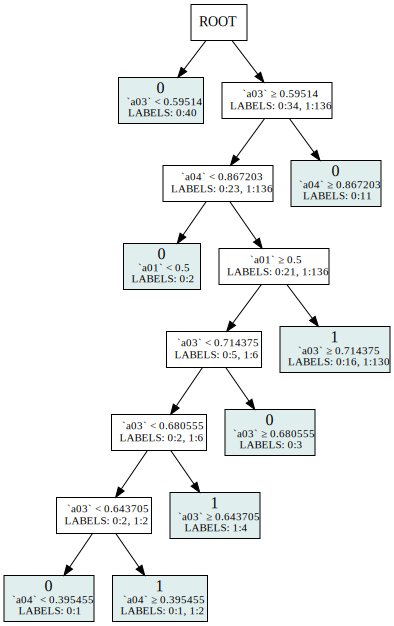

In [4]:
from odps.ml.classifiers import *
train, test = df.min_max_scale(['a01', 'a02', 'a03', 'a04']).split(0.6)

lr = RandomForests(tree_num=10)
model = lr.train(train)
result = model.execute()result[0]

Models can be used for prediction using **predict** method. Here we predict labels on the test set using the model we just created and then store the result. DataFrame methods can be used to do some statistics.

In [5]:
predicted = model.predict(test)
predicted.persist('test_out')
predicted.prediction_result.value_counts().to_pandas()

,prediction_result,count
0,1,98
1,0,43


Then we calculate and plot the ROC curve for the estimation. The true label column is the column designated in field roles, while the predicted label column and score column are 'prediction_result' and 'prediction_score' by default, respectively. After obtaining false positive ratio and true positive ratio, we can plot an ROC curve with *matplotlib*.

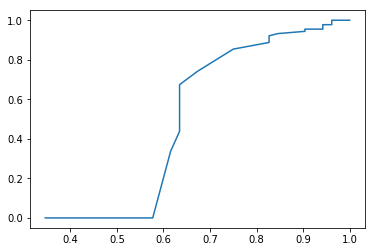

In [6]:
from odps.ml.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

# roc_curve is also an operational node
fpr, tpr, thresh = roc_curve(predicted)
plt.plot(fpr, tpr)

AUC can also be calculated. As we have already run roc_curve, the result is cached and *roc_auc_curve* returns immediately.

In [7]:
from odps.ml.metrics import roc_auc_score
roc_auc_score(predicted)

0.33545808124459808